In [6]:
import regex as re
import collections
import matplotlib.pyplot as plt
import requests

PATTERN_SOURCE = "OpenAI GPT-2 Pre-tokenization Pattern"
GPT2_SPLIT_PATTERN = r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""

In [7]:
def get_stats(ids):
    counts = collections.defaultdict(int)
    for pair in zip(ids, ids[1:]):
        counts[pair] += 1
    return counts

def merge_ids(ids, pair, idx):
    new_ids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            new_ids.append(idx)
            i += 2
        else:
            new_ids.append(ids[i])
            i += 1
    return new_ids

In [8]:
class BPETokenizer:
    def __init__(self, pattern=GPT2_SPLIT_PATTERN):
        self.pattern = pattern
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        self.merges = {}
        self.special_tokens = {}
        self.history_compression = []

    def train(self, text, vocab_size, verbose=False):
        text_chunks = re.findall(self.pattern, text)
        ids = [list(chunk.encode("utf-8")) for chunk in text_chunks]
        
        num_merges = vocab_size - 256
        for i in range(num_merges):
            stats = collections.defaultdict(int)
            for chunk_ids in ids:
                for pair, freq in get_stats(chunk_ids).items():
                    stats[pair] += freq
            
            if not stats:
                break
            
            pair = max(stats, key=stats.get)
            idx = 256 + i
            
            ids = [merge_ids(chunk_ids, pair, idx) for chunk_ids in ids]
            
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
            
            if i % 50 == 0:
                total_tokens = sum(len(chunk) for chunk in ids)
                total_bytes = sum(len(self.vocab[t]) for chunk in ids for t in chunk) 
                ratio = total_bytes / total_tokens if total_tokens > 0 else 0
                self.history_compression.append((256 + i, ratio))

    def add_special_tokens(self, tokens):
        start_idx = 256 + len(self.merges)
        for i, token in enumerate(tokens):
            self.special_tokens[token] = start_idx + i
            self.vocab[start_idx + i] = token.encode("utf-8")

    def encode(self, text):
        for token, idx in self.special_tokens.items():
            if token in text:
                parts = text.split(token)
                encoded_parts = [self.encode(part) for part in parts]
                result = []
                for i, part in enumerate(encoded_parts):
                    result.extend(part)
                    if i < len(encoded_parts) - 1:
                        result.append(idx)
                return result

        text_chunks = re.findall(self.pattern, text)
        ids = []
        for chunk in text_chunks:
            chunk_ids = list(chunk.encode("utf-8"))
            while len(chunk_ids) >= 2:
                stats = get_stats(chunk_ids)
                pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
                if pair not in self.merges:
                    break
                idx = self.merges[pair]
                chunk_ids = merge_ids(chunk_ids, pair, idx)
            ids.extend(chunk_ids)
        return ids

    def decode(self, ids):
        tokens = []
        for idx in ids:
            tokens.append(self.vocab[idx])
        return b"".join(tokens).decode("utf-8", errors="replace")

In [9]:
train_text = """
Машинное обучение — класс методов искусственного интеллекта, характерной чертой которых является не прямое решение задачи, а обучение за счёт применения решений множества сходных задач.
Tokenization is a fundamental step in Natural Language Processing.
Byte pair encoding (BPE) is a simple data compression technique that iteratively replaces the most frequent pair of bytes in a sequence with a single, unused byte.
Python is a high-level, general-purpose programming language.
def function(x): return x + 1
""" * 100

vocab_size = 1000
tokenizer = BPETokenizer()
tokenizer.train(train_text, vocab_size)
tokenizer.add_special_tokens(["<|endoftext|>", "<|pad|>"])

In [10]:
test_text_general = "Машинное обучение и Python помогают решать задачи. Natural Language Processing is cool."
test_text_code = "def solve_task(data): return data.process()"

tokens_general = tokenizer.encode(test_text_general)
tokens_code = tokenizer.encode(test_text_code)

def calculate_metrics(text, tokens):
    text_bytes = text.encode("utf-8")
    compression_ratio = len(text_bytes) / len(tokens)
    
    words = text.split()
    tokens_per_word = len(tokens) / len(words) if words else 0
    
    word_counts = collections.Counter(words)
    top_10_percent_count = int(len(word_counts) * 0.1) if len(word_counts) > 10 else 1
    top_words = {w for w, _ in word_counts.most_common(top_10_percent_count)}
    
    top_tokens = []
    top_word_count = 0
    for word in words:
        if word in top_words:
            top_tokens.extend(tokenizer.encode(word))
            top_word_count += 1
            
    tokens_per_word_top = len(top_tokens) / top_word_count if top_word_count else 0
    
    return compression_ratio, tokens_per_word, tokens_per_word_top

cr_gen, tpw_gen, tpw_top_gen = calculate_metrics(test_text_general, tokens_general)
cr_code, tpw_code, tpw_top_code = calculate_metrics(test_text_code, tokens_code)

print(f"General Domain -> Compression: {cr_gen:.2f}, TPW: {tpw_gen:.2f}, Top-10% TPW: {tpw_top_gen:.2f}")
print(f"Code Domain    -> Compression: {cr_code:.2f}, TPW: {tpw_code:.2f}, Top-10% TPW: {tpw_top_code:.2f}")

if cr_gen > cr_code:
    print("Эффективность выше на общелитературном домене (так как обучали на смешанном тексте с преобладанием текста).")
else:
    print("Эффективность выше на коде.")

General Domain -> Compression: 4.00, TPW: 2.58, Top-10% TPW: 1.00
Code Domain    -> Compression: 1.79, TPW: 6.00, Top-10% TPW: 1.00
Эффективность выше на общелитературном домене (так как обучали на смешанном тексте с преобладанием текста).


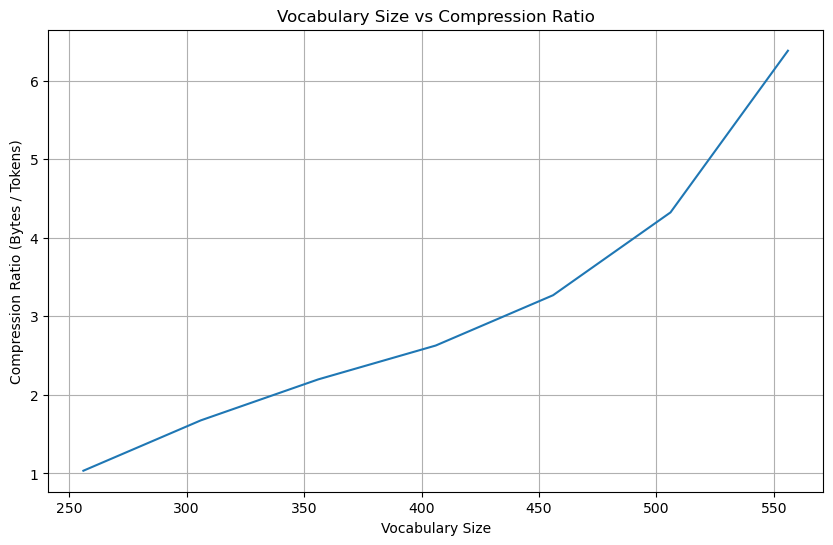

In [11]:
sizes, ratios = zip(*tokenizer.history_compression)

plt.figure(figsize=(10, 6))
plt.plot(sizes, ratios)
plt.title("Vocabulary Size vs Compression Ratio")
plt.xlabel("Vocabulary Size")
plt.ylabel("Compression Ratio (Bytes / Tokens)")
plt.grid(True)
plt.show()

In [12]:
try:
    url = "https://raw.githubusercontent.com/attreyu/pushkin-poems/master/pushkin.txt"
    response = requests.get(url)
    pushkin_text = response.text[:50000]
    
    pushkin_tokens = tokenizer.encode(pushkin_text)
    
    unique_tokens_used = set(pushkin_tokens)
    total_vocab_size = len(tokenizer.vocab)
    unused_tokens_count = total_vocab_size - len(unique_tokens_used)
    unused_percentage = (unused_tokens_count / total_vocab_size) * 100
    
    print(f"Всего токенов в словаре: {total_vocab_size}")
    print(f"Использовано уникальных токенов в Пушкине: {len(unique_tokens_used)}")
    print(f"Не использовано токенов: {unused_tokens_count}")
    print(f"Процент неиспользованных токенов: {unused_percentage:.2f}%")

except Exception as e:
    print(f"Не удалось загрузить или обработать текст Пушкина: {e}")

Всего токенов в словаре: 568
Использовано уникальных токенов в Пушкине: 10
Не использовано токенов: 558
Процент неиспользованных токенов: 98.24%
